In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [2]:
from nltk.stem.porter import PorterStemmer
import re
import nltk
from nltk.tokenize import word_tokenize
import pkg_resources
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from symspellpy import SymSpell, Verbosity

sym_spell = SymSpell(max_dictionary_edit_distance=3, prefix_length=7)
dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt")
if sym_spell.word_count:
    pass
else:
    sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)

# normalization
def func_norm(s):
    """
    Perform some basic normalisation operations.

    Parameters
    ----------
    s:  str
        text to operate on
    
    Returns
    -------
        Normalised string
    
    """
    s = s.lower() # lower case
    # letter repetition (>2)
    s  = re.sub(r'([a-z])\1{2,}', r'\1', s)
    # non word repetition
    s = s = re.sub(r'([\W+])\1{1,}', r'\1', s)
    # noise text
    s = re.sub(r' ing ', ' ', s)
    # phrase repetition
    s = re.sub(r'(.{2,}?)\1{1,}', r'\1', s)

    return s.strip()

def func_punc(w_list):
    """
    Remove non-alphabet characters. Includes punctuation.

    Parameters
    ----------
    w_list: list
        list of tokens to be processed
    
    Returns
    -------
        list without non-alphabet characters
    """
    return [word for word in w_list if word.isalpha()]

def func_stopf(w_list):
    """
    Remove stop words

    Parameters
    ----------
    w_list: list
        list of tokens to be processed
    
    Returns
    -------
        list without stop words
    """
    stop_words = set(stopwords.words('english'))
    w_list  = [f for f in w_list if f not in stop_words]
    return w_list

# stemming
pstem = PorterStemmer()

def func_stem(w_list):
    """
    stem word list

    Parameters
    ----------
    w_list: list
        word list for stemming

    Returns
    -------
        stemmed word list 
    """
    sw_list = [pstem.stem(w) for w in w_list]
    return sw_list

# selecting nouns
def func_noun(w_list):
    """
    in: word list to be processed
    out: w_list with only nouns selected
    """
    return [word for (word, pos) in nltk.pos_tag(w_list) if pos[:2] == 'NN']

def func_verb(w_list):
    """ 
    Parameters
    ----------
    w_list: list
        list of tokens to be processed
    Returns
    -------
        list of verbs only
    """
    return [word for (word,pos) in nltk.pos_tag(w_list) if pos[:2] == 'VB']

def func_adjective(w_list):
    """ 
    Parameters
    ----------
    w_list: list
        list of tokens to be processed
    Returns
    -------
        list of verbs only
    """
    return [word for (word,pos) in nltk.pos_tag(w_list) if pos[:2] == 'JJ']

def func_inf_words(w_list):
    """ 
    Retain verbs, adjectives and nouns only

    Parameters
    ----------
    w_list: list
        list of words to be processed
    Returns
    -------
    list of nouns, adjectives and verbs only
    """
    return [word for (word,pos) in nltk.pos_tag(w_list) if 'VB' in pos or 'JJ' in pos or 'NN' in pos]

# spell checker/typo correction
def func_spell(w_list):
    """
    in: word list to be processed
    out: w_list with typo fixed by symspell. words with no match up will be dropped
    """
    w_list_fixed = []
    for word in w_list:
        if 'covid' in word:
            w_list_fixed.append(word)
        else:
            suggestions = sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=3)
            if suggestions:
                w_list_fixed.append(suggestions[0].term)
            else:
                pass
    return w_list_fixed

def preprocess_sent(rw):
    """
    Get sentence level preprocessed data from raw texts

    Parameters
    ----------
        rw: str
            sentence to be processed

    Returns
    -------
        sentence level pre-processed text
    """
    s = func_norm(rw)

    return s



def preprocess_word(s):
    """
    Get word level preprocessed data from preprocessed sentences.
    
    Parameters
    ----------
    s:  str
        sentence to be processed
    
    Returns
    -------
        word level pre-processed text
    """
    if not s:
        return None
    w_list = word_tokenize(s)
    w_list = func_punc(w_list)
   # w_list = func_inf_words(w_list)
    w_list = func_spell(w_list)
   # w_list = func_stem(w_list)
    w_list = func_stopf(w_list)

    return w_list

def preprocess(docs):
    """
    Preprocess the data.

    Parameters
    ----------
    docs: list
        list of documents to be preprocessed
    
    Returns
    -------
        Preprocessed sentences, tokens
    """
    print('Preprocessing raw texts ...')
    #n_docs = len(docs)
    sentences = []  # sentence level preprocessed
    token_lists = []  # word level preprocessed
    #samp = np.random.choice(n_docs)
    for i in range(0, len(docs)):
        sentence = preprocess_sent(docs.iloc[i])
        token_list = preprocess_word(sentence)
        if token_list:
            sentences.append(sentence)
            token_lists.append(token_list)
        print('{} %'.format(str(np.round((i + 1) / len(writing_df.writing) * 100, 2))), end='\r')
    print('Preprocessing raw texts. Done!')
    return sentences, token_lists

utils

In [26]:
import scikit_posthocs as sp
from scipy import stats
from textblob import TextBlob
import statsmodels.api as sm
import statsmodels.formula.api as smf
from nltk import FreqDist

def kruskal_wallis_func(in_df, group_col, test_col):
    """
    Kruskal Wallis test and
    post-hoc Dunn's.

    Parameters
    ----------
    in_df:  pd DataFrame
        input dataframe
    group_col:  str
        name of group column
    test_col:   str
        name of column containing
        relevant values

    Returns
    -------
    Statistic, pvalue
    """
    data = in_df.pivot(columns = group_col, values = test_col)
    if len(in_df[group_col].unique())>2:
            statistic,pval = stats.kruskal(data.iloc[:,0],data.iloc[:,1],
            data.iloc[:,2],nan_policy = 'omit')
            posthoc = sp.posthoc_dunn(
                        [data.iloc[:,0].dropna(),data.iloc[:,1].dropna(),data.iloc[:,2].dropna()],
                        p_adjust = 'bonferroni'
                        )
            key = [data.columns[0],data.columns[1],data.columns[2]]
    else:
        statistic,pval = stats.kruskal(data.iloc[:,0],data.iloc[:,1],
        nan_policy = 'omit')
        posthoc = None
        key = None
    return statistic,pval, posthoc, key


def get_sentiment(in_df, in_col):
    """
    Get subjectivity
    and polarity scores.

    Parameters
    ----------
    in_df:  pd DataFrame
        DataFrame to operate on
    in_col: str
        column holding text data
        to operate on
    
    Returns
    -------
    Input DataFrame with
    subjectivity/polarity columns
    added.

    """
    print("Getting sentiment scores...")
    in_df = in_df.assign(
                        polarity = in_df[in_col].astype('str').apply(
                        [lambda x: TextBlob(x).sentiment.polarity]),
                        subjectivity = in_df[in_col].astype('str').apply(
                        [lambda x: TextBlob(x).sentiment.subjectivity])
                        )
    print("Done!")
    return in_df

def run_mixedlm(in_df,group_name,formula, re_intercept):
    """ 
    Run statsmodels LMEM.

    Parameters
    ----------
    in_df:  pandas DataFrame
        input dataframe
    group_name: str
        column to group by
    formula:    str
        patsy formula

    Returns
    -------
    MixedLMResults instance
    """
    if re_intercept:
        model = smf.mixedlm(
                            formula, in_df, groups = group_name,re_formula = re_intercept, missing = 'drop'
                            ).fit()
    else:
        model = smf.mixedlm(formula, in_df, groups = group_name,missing = 'drop').fit()
    return model

def run_gee(in_df,group_name,formula,cov_structure, resp_family):
    """ 
    Run statsmodels GEE.

    Parameters
    ----------
    in_df:  pandas DataFrame
        input dataframe
    group_name: str
        column to group by
    formula:    str
        patsy formula
    cov_structure:  sm covariance structure
        covariance structure (e.g. sm.cov_struct.Independence())
    resp_family:    sm family (e.g. sm.families.Tweedie())
        mean response structure distribution

    Returns
    -------

    """
    model = smf.gee(formula,group_name, in_df, cov_struct = cov_structure, family = resp_family,missing = 'drop').fit()
    
    return model

def flatten_list(list_of_lists):
    """
    Flatten list of lists.

    Parameters
    ----------
    list_of_lists:  list
        list of lists to flatten
    
    Returns
    -------
    Flattened list.
    """
    return [item for sub_list in list_of_lists for item in sub_list]


def get_top_words(day_col, num_day, group_col, group_name, in_df, token_col_name, **pos_tag_type):
    """ 
    Get an ordered list of words in document.

    Parameters
    ----------
    day_col:    str
        Name of df column indicating day of writing
    num_day:    int
        Day of writing (1, 2, 3 or 4)
    group_col:  str
        Name of group column in df
    group_name: str
        The group to process (EW, EWRE or CTR)
    in_df:  pd DataFrame
        input dataframe containing rel data
    token_col_name: str
        Name of column containing tokenized text
    **pos_tag_type: str/list of str
        If processing only nouns/verbs/adjectives
        pass tag to function using kwargs.
        For adjectives, use:
        'JJ'
        For verbs, use:
        'VB'
        For nouns, use:
        'NN'
        If all of the above, pass list:
        ['NN','JJ','VB']
        as kwarg.

    Returns
    -------
    list of words, list of vals
    words = words ordered from most frequent to rare
    vals = corresponding frequency
    """
    token_list = [
                item for sublist in
                [*in_df.loc[
                (in_df[group_col] == group_name) &
                (in_df[day_col] == num_day),
                token_col_name]]
                for item in sublist
                ]

    
    if pos_tag_type:
        selected_list = []
        for tag_type in pos_tag_type.values():
            w_list = [
                    word for (word,pos) 
                    in nltk.pos_tag(token_list)
                    for tag in tag_type
                    if pos[:2] == tag
                    ]
            selected_list.extend(w_list)
    else:
        selected_list = token_list
    selected_list = func_stem(selected_list)
    freqs = FreqDist(selected_list)
    common_tups = freqs.most_common()
    common_words = list(zip(*common_tups))[0]
    common_vals = list(zip(*common_tups))[1]
    return common_words, common_vals

def func_top_words(in_df, pos_tags, visualize):
    """
    Put top 50 words in dataframe,
    with option to visualize using barplots.

    Parameters
    ----------
    in_df:  pd DataFrame
    input dataframe
    pos_tags:   list
        list of pos tags to use
        can be VB, JJ, NN or
        any combination (or all) of these
    visualize:  int
    1 if visualization is needed
    0 otherwise

    Returns
    -------
    Datframe of 50 top words
    and their frequencies for 
    all days and conditions.

    """

    top_50_words = []
    top_50_vals = []
    condition = []
    days = []

    for group_name in in_df.Group.unique():
        for day in in_df.day.unique():
            words,vals= get_top_words('day', day, 'Group', group_name, in_df, 'writing_tokens', pos_tags = pos_tags)
            top_50_words.append(list(words[:50]))
            top_50_vals.append(list(vals[:50]))
            condition.append(np.repeat(group_name,50))
            days.append(np.repeat(day,50))

    data = {
        'words': flatten_list(top_50_words),
        'vals': flatten_list(top_50_vals),
        'day': flatten_list(days),
        'group': flatten_list(condition)
        }
    most_common_words_df = pd.DataFrame(data)

    if visualize:
        for num_day in most_common_words_df.day.unique():
            fig,axes = plt.subplots(3,1,figsize = (30,15),sharey = True)
            for i,group_name in enumerate(most_common_words_df.group.unique()):
                data = most_common_words_df.loc[
                                                (most_common_words_df.day==num_day) &
                                                (most_common_words_df.group == group_name),
                                                ['words','vals']
                                                ]
                sns.barplot(ax=axes[i], x=data.words, y=data.vals)
                axes[i].set_title(f'Condition: {group_name}, Day: {num_day}')

    return most_common_words_df

In [4]:
home = 1
if home:
    infiledir = r"C:\Users\Luzia T\UCL\WorkingFromHome\Possible_online_studies\NLP_expressive_writing\analysis\Processed_2"
    writing_dir = r"C:\Users\Luzia T\UCL\WorkingFromHome\Possible_online_studies\NLP_expressive_writing\analysis\writing_data\statements"
else:
    infiledir = r"P:\EW_analysis\analysis\Processed_2"
    writing_dir = r"P:\EW_analysis\analysis\writing\writing_data"

In [5]:
writing_df = pd.read_csv(os.path.join(writing_dir, 'writing_df.csv'))

In [ ]:
sentences,tokens = preprocess(writing_df.writing)
writing_df = writing_df.assign(
                                writing_tokens=tokens,
                                writing_sents = sentences
                                )
writing_df = writing_df.assign(
                                word_count = writing_df.writing_tokens.apply(len)
                                )
writing_df = writing_df.assign(
                                word_count_raw =
                                writing_df.writing.apply(lambda x: len(x.split()))
                                )
writing_df = get_sentiment(writing_df,'writing')
for val in ['word_count','word_count_raw','polarity','subjectivity']:
        # check whether word count is significantly different between conditions:
        _, pval, posthoc, key = kruskal_wallis_func(
                                        writing_df,'Group', val
                                        )
        print(f"\nP value ({val}) is {pval}.")
        if pval<0.05:
                print(f"Conditions differ significantly on {val}.")
                print(f"Posthoc ({val}) is:\n{posthoc}.")
                print(f"The key is 1 = {key[0]}, 2 = {key[1]}, 3 = {key[2]}")
        else:
                print(f"No significant between group differences on {val}.")

In-depth analysis of between-condition differences (EW/EWRE)
(i) There should be no differences between EW & EWRE on D1.
(ii) D2: effects/responsibility
(iii) D3: different angles/perspectives
(iv) D4: learnt/gained/future perspectives
Change in most frequent words?
Change in polarity?

Day-by-day changes, comparing EW and EWRE

In [47]:
model_polarity_gee = run_gee(
                            writing_df[writing_df.Group.isin(['EW','EWRE'])],
                            "id", "polarity ~ C(day) * C(Group)",
                            cov_structure = sm.cov_struct.Independence(),
                            resp_family = sm.families.Gaussian()
                            )

print(model_polarity_gee.summary2())

                               Results: GEE
Model:                  GEE                  AIC:                -720.9234 
Link Function:          identity             BIC:                -1804.5687
Dependent Variable:     polarity             Log-Likelihood:     368.46    
Date:                   2022-01-03 18:16     LL-Null:            361.83    
No. Observations:       321                  Deviance:           1.8924    
Df Model:               7                    Pearson chi2:       1.89      
Df Residuals:           313                  Scale:              0.0060460 
Method:                 IRLS                                               
---------------------------------------------------------------------------
                              Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
---------------------------------------------------------------------------
Intercept                     0.0400   0.0102  3.9338 0.0001  0.0201 0.0600
C(day)[T.2]                   0.0060   0.015

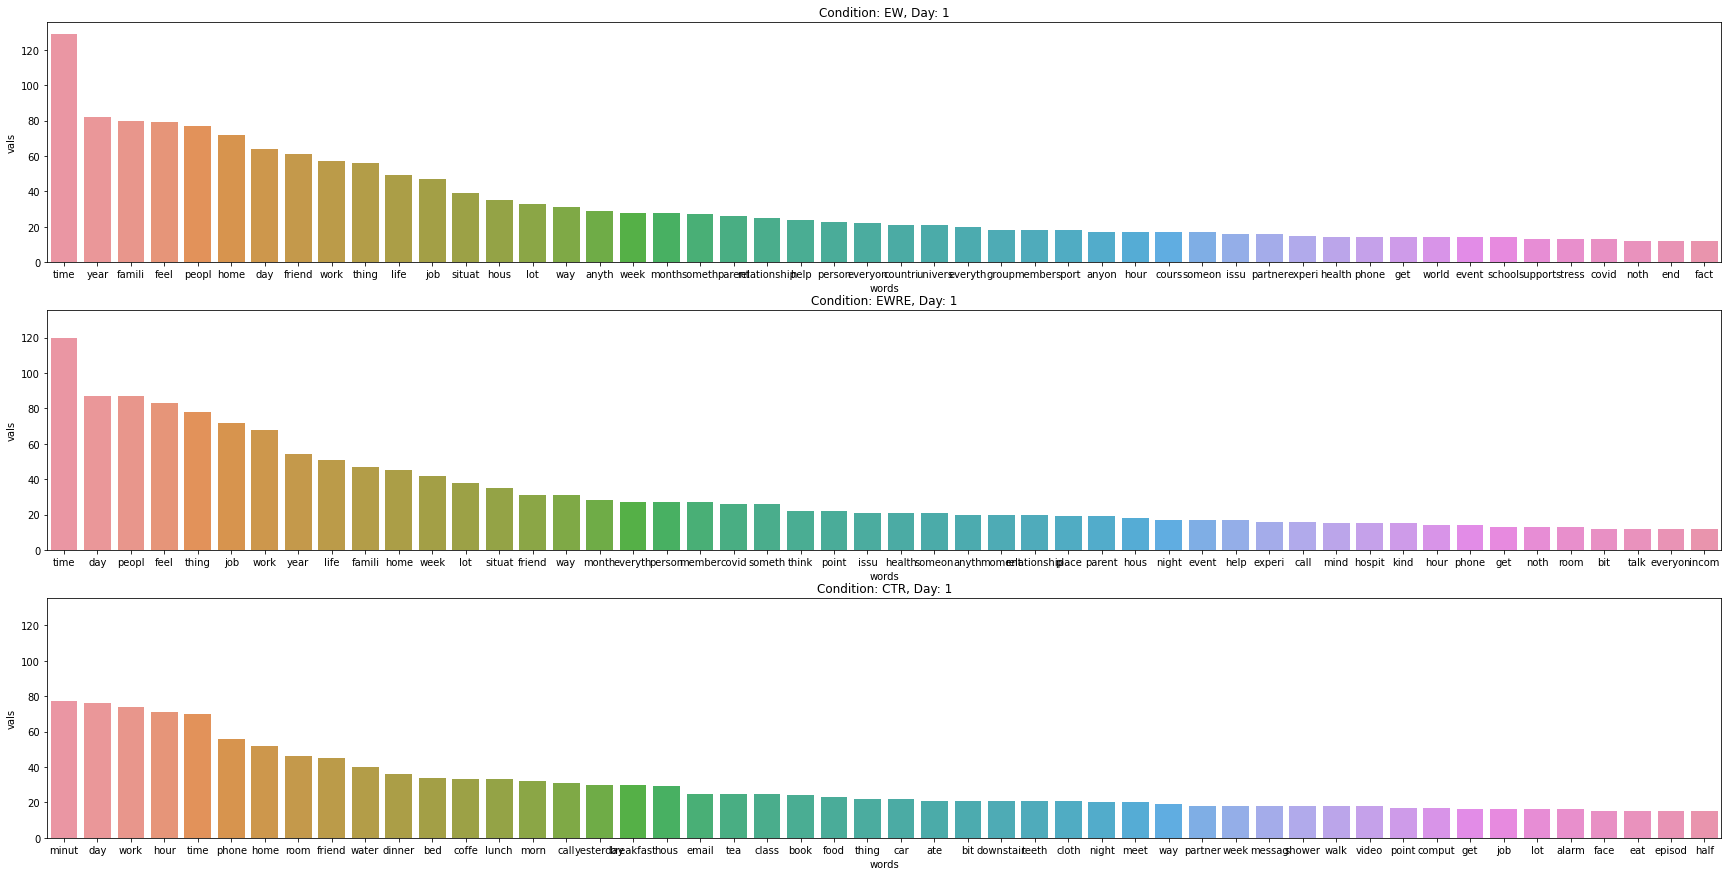

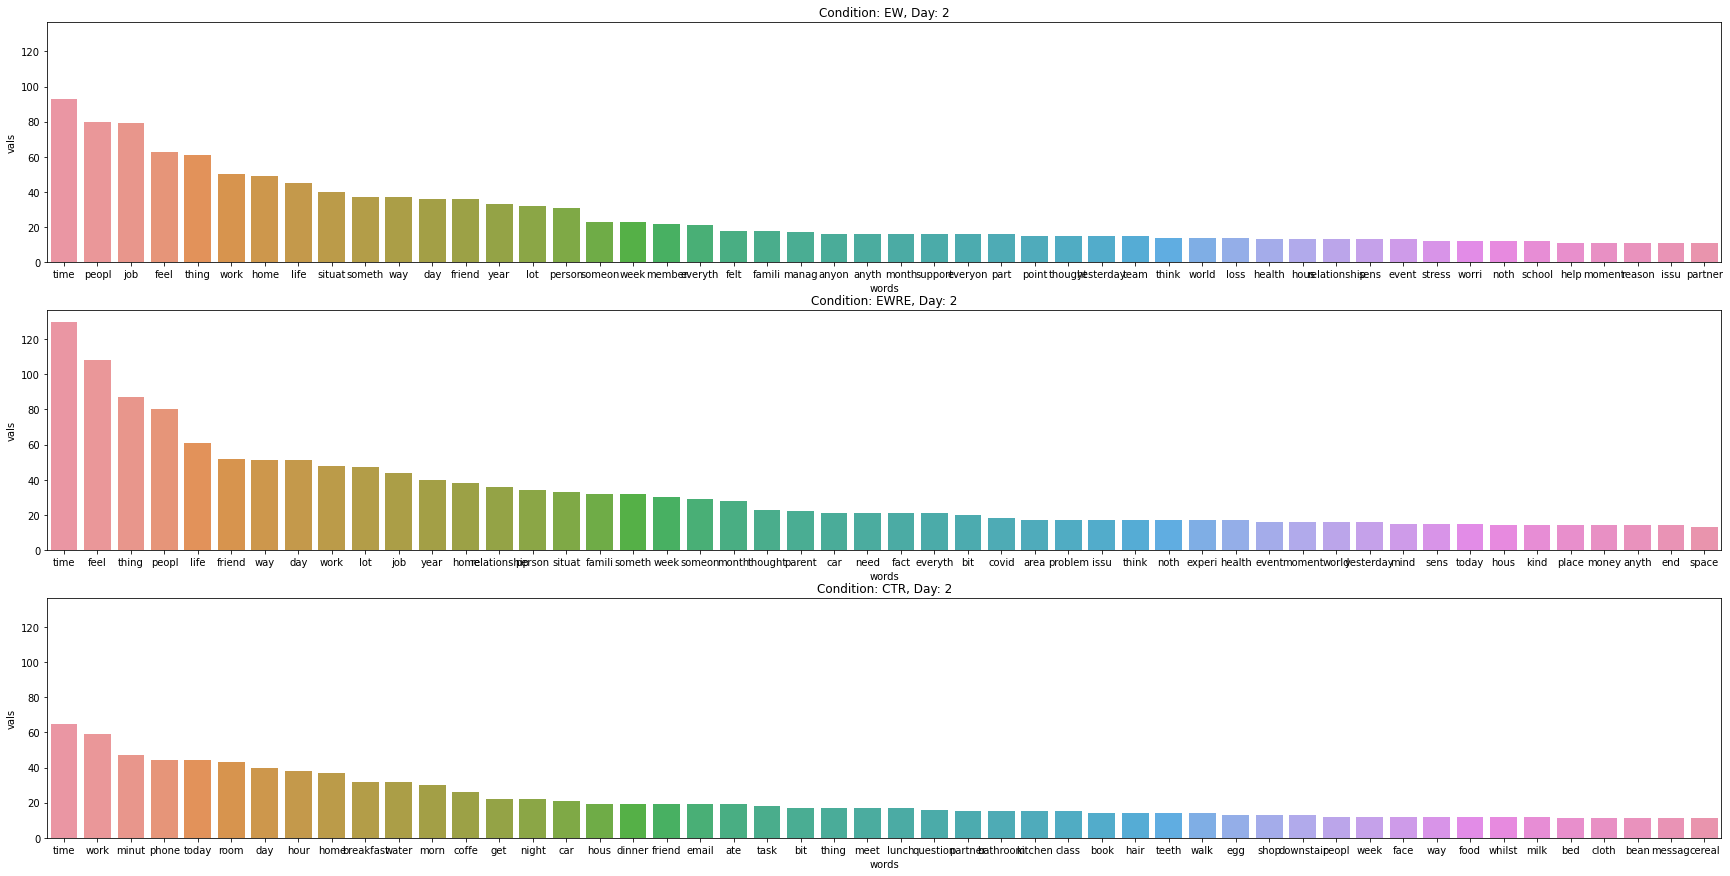

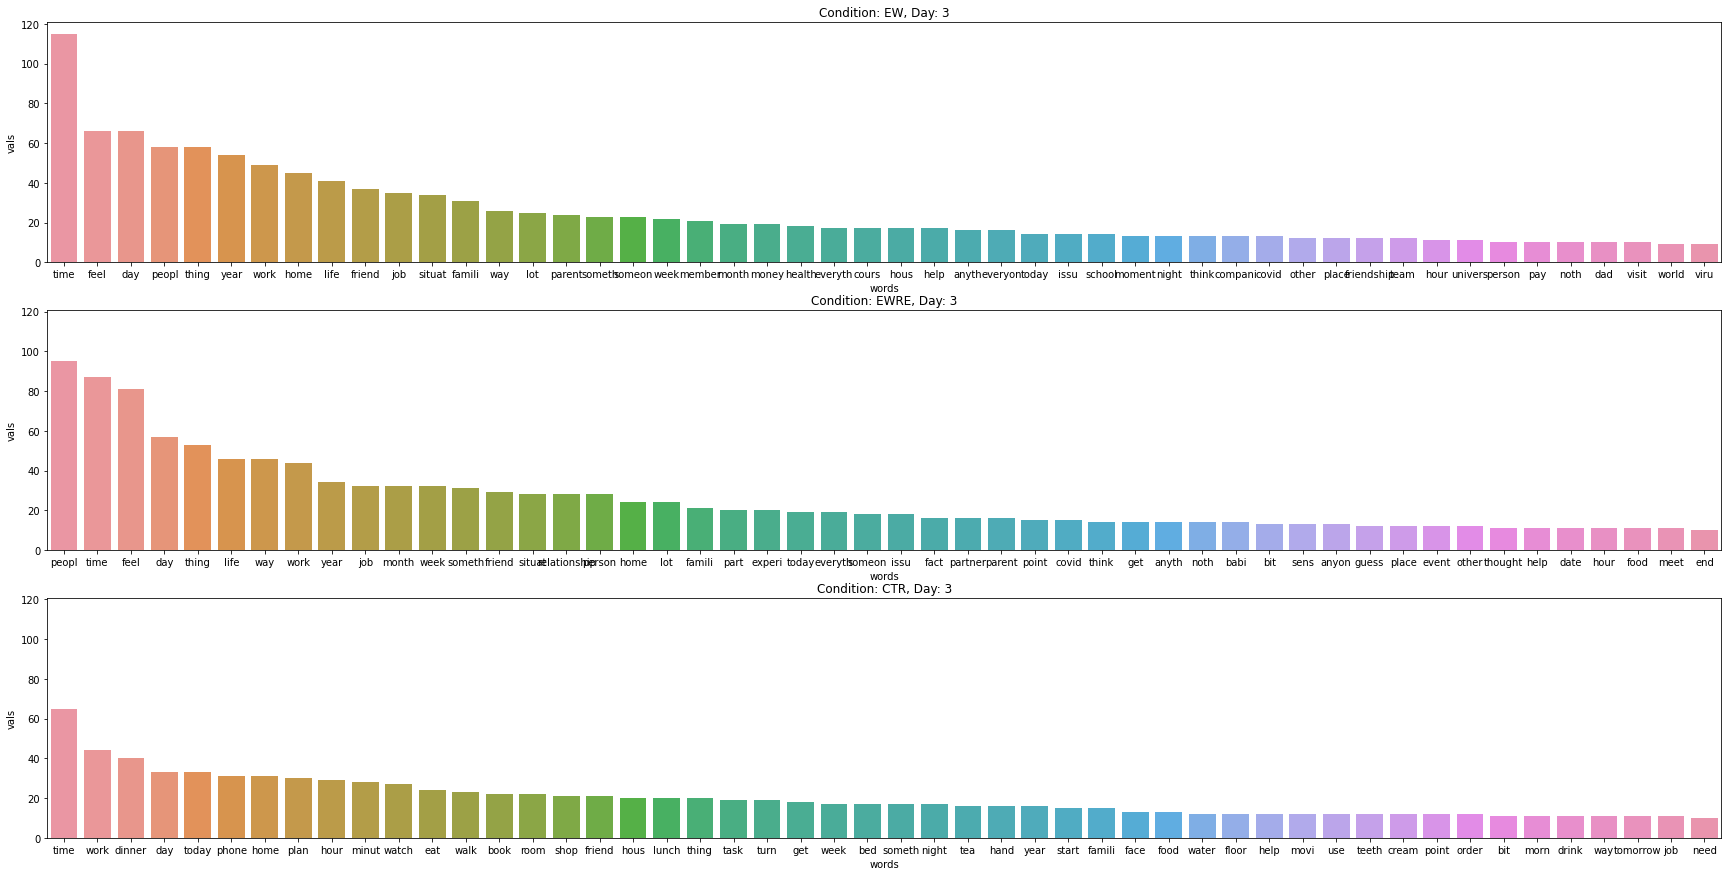

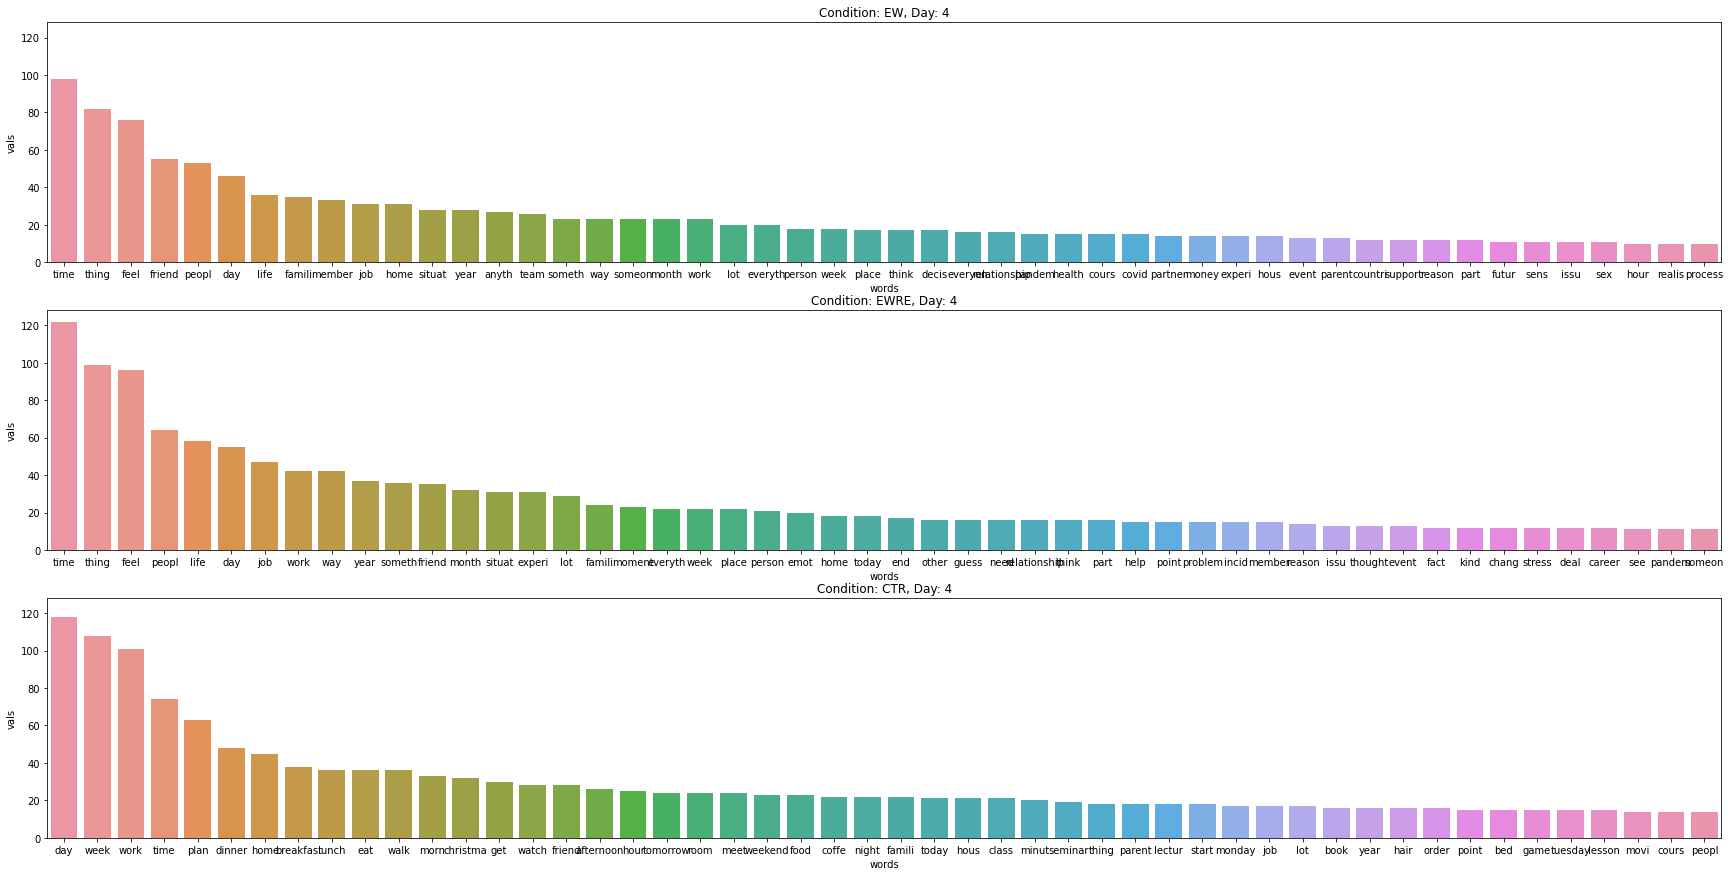

In [48]:
most_common_words_df = func_top_words(writing_df, ['NN'],1)